# How to evaluate policies when the model is unknown
When the model is known, we can perform optimal control using value iteration, policy iteration, modified policy iteration to find the optimal policy. All these models iterate a policy evaluation step and a policy improvement step.

When the model is unknown, the previous models do not work mostly because we do not know how to perform policy evaluation. This practical session is about performing policy evaluation when the model is unknown.

We will see the following algorithms:
- Monte-Carlo (MC)
- Temporal difference ($TD(0), TD(\lambda)$ with eligibility traces)

In [1]:
# To run cells, push MAJ-ENTER or click on the play button at the left of the cells
# Please turn-off AI: from the Tools menu, select Settings, followed by AI assistance. In that space, you'll be able to revoke consent and hide AI coding features.

In [2]:
# Install some additional dependencies
!pip install rlclass --upgrade

  Preparing metadata (setup.py) ... done
  Created wheel for rlclass: filename=rlclass-0.0.5-py3-none-any.whl size=5633 sha256=08abc49ca053802b50f96116a5de83fac8e8729325098d15f42f09ba26822dcb
  Stored in directory: /root/.cache/pip/wheels/76/84/61/5a2d122e9c164814a8710db30005a9e11e5d30d2d0f06c1e52
Successfully built rlclass


In [3]:
# Let us first install gymnasium
!pip install swig gymnasium matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.6 MB/s eta 0:00:00


In [4]:
# Many environment are available
import gymnasium
gymnasium.envs.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v3', 'LunarLanderContinuous-v3', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v3', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Reacher-v5', 'Pusher-v2', 'Pusher-v4', 'Pusher-v5', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'HalfCheetah-v5', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Hopper-v5', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Swimmer-v5', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Walker2d-v5', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'Humanoid-v5

# Frozen Lake

We will play in the Frozen Lake environment. In this environment, the goal is for the player to reach the gift without falling into any holes.

In the map description, S is the starting state, F is a frozen cell, H is a hole and G is the goal to reach.
[['S' 'F' 'F' 'F']
 ['F' 'H' 'F' 'H']
 ['F' 'F' 'F' 'H']
 ['H' 'F' 'F' 'G']]


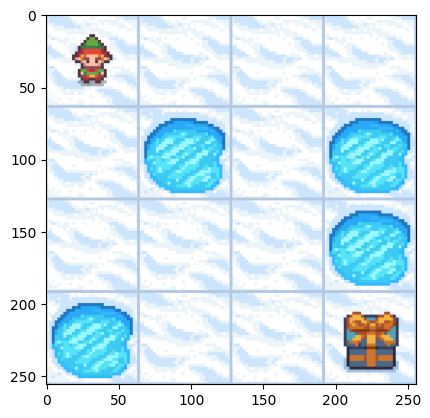

In [5]:
import numpy as np
import matplotlib.pyplot as plt

map = [list("SFFF"), list("FHFH"), list("FFFH"), list("HFFG")]
print("In the map description, S is the starting state, F is a frozen cell, H is a hole and G is the goal to reach.")
print(np.array(map))
env = gymnasium.make('FrozenLake-v1', render_mode="rgb_array", desc=map, is_slippery=False)
s0, _ = env.reset()
plt.imshow(env.render())


**Action Space**

The action shape is (1,) in the range {0, 3} indicating which direction to move the player.

    0: Move left

    1: Move down

    2: Move right

    3: Move up


In [6]:
print(env.action_space)

Discrete(4)


**Observation Space**

The observation is a value representing the player’s current position as current_row * ncols + current_col (where both the row and col start at 0).The observation is returned as an int().

In [7]:
print(env.observation_space)

Discrete(16)


**Reward schedule**

    Reach goal: +1

    Reach hole: 0

    Reach frozen: 0

**Episode End**

The episode ends if the following happens:

    Termination:

        The player moves into a hole.

        The player reaches the goal at max(nrow) * max(ncol) - 1 (location [max(nrow)-1, max(ncol)-1]).

In [8]:
from rlclass.utils import make_animation

# Exercise 1:
Implement a policy `pi_uniform` that selects an action uniformly at random at every state

In [9]:
n_actions, n_states = env.action_space.n, env.observation_space.n
def play_policy(env, pi, horizon=20):
  """
  env: the environment
  pi: np array of shape (n_actions, n_states)
    pi[a, s] is the probability to play action a when in state s
  horizon: int
  """
  n_actions, n_states = pi.shape
  # Check that pi is a probability distribution
  if np.sum((np.sum(pi, axis=0) - 1) ** 2) >= 1e-10:
    print("The policy pi is not a valid policy: each column must sum to 1")
  np.testing.assert_allclose(np.ones(n_states), np.sum(pi, axis=0))
  s, _ = env.reset()
  a = np.argmax(np.random.multinomial(1, pi[:, s]))
  imgs = []
  imgs.append(env.render())
  for _ in range(horizon):
    s, rew, term, trunc, _ = env.step(a)
    a = np.argmax(np.random.multinomial(1, pi[:, s]))
    imgs.append(env.render())
    if term or trunc:
      break
  return make_animation(imgs)

# TODO implement a uniform policy that chooses each action uniformly at random
pi_uniform = (1 / n_actions)* np.ones((n_actions, n_states))

In [10]:
play_policy(env, pi_uniform)

# Comparator

In order to know how good our methods are, we will compare their result to the optimal quantities (obtained via model-based methods i.e. the techniques we saw in the last practical session).

The state value function is defined by:
$$
v^{\pi}(s) = \mathbb{E}[\sum_{t=0}^\infty \gamma^t r_{A_t}(S_t) | S_0 = s].
$$

The goal of this part is to evaluate the state-action value function
$$
q^{\pi}(s, a) = \mathbb{E}[\sum_{t=0}^\infty \gamma^t r_{A_t}(S_t) | S_0 = s, A_0=a].
$$

We recall that both quantities are linked through the identity:
$$
q^{\pi}(s, a) = r_a(s) + \gamma \mathbb{E}[v^{\pi}(S_1) | S_0 = s, A_0 = a].
$$


In [11]:
from rlclass.td2 import compute_qpi, policy_iteration

In [12]:
gamma = 0.9
n_iterations = 100
qpi_uniform = compute_qpi(env, pi_uniform, gamma)
pi_star = policy_iteration(env, n_iterations, gamma)
play_policy(env, pi_star)

# Simulator access
In the following, we will assume that we do not access the model but have access to a simulator that allows you to start from whatever position you like and experiment.
To do so, we will implement a custom version of the environment.

In [13]:
from rlclass.td2 import simulated_env
simulated_env?

We can use the simulator to emulate several trajectories in the same environment at starting state we choose.

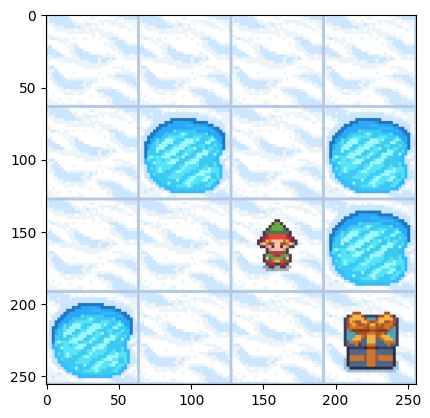

In [14]:
starting_position = 10
senv, pos = simulated_env(starting_position)
if senv is not None:
  senv.reset()
  plt.imshow(senv.render())

# Learning a state-action value function via Monte Carlo using a simulator

Let us simulate an environment with starting state $s$ and play action $a$ in the first step and follow policy $\pi$ in subsequent steps. We obtain a trajectory $S_0, A_0, R_0 = r_{A_0}(S_0), S_1, A_1, R_1, \cdots, S_T, A_T, R_T$.
An estimate of $q^{\pi}(s, a)$ is given  by:
$$
G = \sum_{t=0}^T \gamma^t R_t.
$$
The Monte Carlo method consists in estimating $m$ trajectories starting from $s_0$ as above which yields multiple trajectories:
\begin{align*}
&S_0^{(0)}, A_0^{(0)}, R_0^{(0)}, \dots, S_{T^{(0)}}, A_{T^{(0)}}, R_{T^{(0)}} \\
&\vdots \\
&S_0^{(m)}, A_0^{(m)}, R_0^{(m)}, \dots, S_{T^{(m)}}, A_{T^{(m)}}, R_{T^{(m)}}
\end{align*}
then estimate:
\begin{align*}
&G^{(0)} = \sum_{t=0}^{T^{(0)}} \gamma^t R_t^{(0)} \\
&\vdots \\
&G^{(m)} = \sum_{t=0}^{T^{(m)}} \gamma^t R_t^{(m)}
\end{align*}
the Monte Carlo estimate of $q^{\pi}(s, a)$ is then given by:
$$
\tilde{q}^{\pi}(s, a) = \frac1{m} \sum_{i=1}^m G^{(i)}
$$

# Exercise 2
Using the simulator, compute the q-value function of the random policy using Monte-Carlo. Compare with the solution obtained with the closed form.

In [15]:
def discounted_return_trajectory(s0, a0, pi, gamma, max_horizon, rng=None):
    """
    Computes the discounted return of a trajectory starting from a given
    state-action pair and following a given policy afterwards on the
    Frozen Lake environment. This produce a sequence (s0, a0, ...,).

    The discounted return is defined by:
    sum_{k=0}^\infty \gamma^k r_{ak}(sk)

    Parameters
    ----------
    s0: int
      Starting state
    a0: int
      Starting action
    pi: (n_actions, n_states) np array
      Policy
    gamma: float
      Discount factor
    max_horizon: int
      If after max_horizon steps,
      no terminal state is reached, the computation stops
      with a return of 0.
    rng: int or None or np.random.RandomState object
      The random seed / RandomState

    Return
    ------
    return: float
      The discounted return of the trajectory.
    """
    rng = np.random
    env, pos = simulated_env(s0)
    if env is None:
      return 0
    env.reset()
    s, rew, term, trunc, _ = env.step(a0)
    for k in range(max_horizon):
      if term:
        if rew == 1:
          return gamma ** k
        if rew == 0:
          return 0
      a = np.argmax(rng.multinomial(1, pi[:, s]))  #choisit une action a selon la distribution de probas donnée par la politique pi pour l’état courant s
      s, rew, term, trunc, _ = env.step(a)
    return 0

def q_pi_mc(pi, gamma, n_trajectories, max_horizon=300, step_size=lambda x: 1/x, q_true=None):
  """
  Estimate the q-value function using monte-carlo.
  Starting from q(s, a) = 0 for all s, a, iterate
  q(s, a) = q(s, a) + step_size (G(s, a) - q(s, a))
  wherre G(s, a) is the discounted return of the trajectory starting at s, a.

  Parameter
  ---------
  pi: (n_actions, n_states) np array
    Policy
  gamma: float
    Discount factor
  n_trajectories: int
    Number of trajectories that are sampled to compute the MC estimate
  max_horizon: int
    For each trajectories, if after max_horizon steps,
      no terminal state is reached, the computation stops
      with a return of 0.
  step_size: float -> float or float
    The step size.
    If it is a function, the step-size used for the t-th trajectory is given by
    step_size(t).
  q_true: np array of size (n_states, n_actions)
    The state action value function returned using the model
  Return
  -------
  Q: np array of size (n_states, n_actions)
    q-value function
  errors: np array of size (n_trajectories,) (only returned if q_true is not None)
    l_infinity errors between the q_true and the current Q value.
  """
  rng = np.random
  n_actions, n_states = pi.shape
  Q = np.zeros((n_states, n_actions))
  errors = []
  for t in range(n_trajectories):
    for s in range(n_states):
      for a in range(n_actions):
        if type(step_size) == float:
          alpha = step_size
        else:
          alpha = step_size(t+1)
        Q[s,a] += alpha * (discounted_return_trajectory(s, a, pi, gamma, max_horizon, rng) - Q[s,a])
    if q_true is not None:
      errors.append(np.max(np.abs(Q - q_true)))
  if q_true is not None:
    return Q, errors
  return Q


In [16]:
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
gamma = 0.9
qpi_cf = compute_qpi(env, pi_uniform, gamma)
qpi_mcs = []

n_trajectories = 40

n_runs = 20
step_sizes = [lambda x: 1/x, 1/5]
res_mc = []
for step_size in step_sizes:
  res_mc.append(Parallel(n_jobs=-1)(delayed(q_pi_mc)(pi_uniform, gamma, n_trajectories, step_size=step_size, q_true=qpi_cf) for r in range(n_runs)))

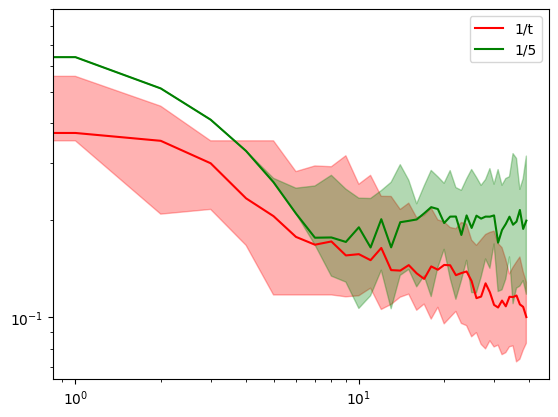

In [17]:
step_sizes = [lambda x: 1/x, 1/5]
labels = ["1/t", "1/5"]
colors = ["red", "green"]
plt.figure()
for i in range(len(step_sizes)):
  errors = np.array([res_mc[i][k][1] for k in range(n_runs)])
  plt.loglog(np.arange(n_trajectories), np.median(errors, axis=0), label = labels[i], color=colors[i])
  plt.fill_between(np.arange(n_trajectories), np.quantile(errors, 0.1, axis=0), np.quantile(errors, 0.9, axis=0), color=colors[i], alpha=0.3)
plt.legend()

# Learning a state-action value function via TD(0) using a simulator

The state-action value function $q^{\pi}$ satisfies:
\begin{align*}
q^{\pi}(s, a) &= (T^{\pi} q^{\pi})(s, a) \\
&=  r_a(s) + \gamma \mathbb{E}[q^{\pi}(S_1, A_1) | S_0=s]
\end{align*}

Given a tuple $(s, a, r_{a}(s), s', a')$ where $s'$ is obtained by playing action $a$ in state $s$ and $a'$ is obtained by following policy $\pi$ at state $s'$, an unbiased estimate of $T^{\pi}(q)$ is given by
$$
\tilde{T^{\pi}}(q) = r_a(s) + \gamma q(s', a').
$$

TD(0) uses this unbiased estimate in order to find the fixed point of $T^{\pi}$ via stochastic approximation. A practical implemention is as follows:

Starting from $\tilde{q}_0 = 0$ iterate
* For every state,action pair $(s, a)$ collect a samples $(s, a, s', a')$ where $s' \sim P_a(s)$ and $a' \sim \pi(\cdot | s')$
* Perform for every $s, a$ the updates
$$
\tilde{q}_{t+1}(s, a) = \tilde{q}_t(s, a) + \alpha_t ( r_a(s) + \gamma \tilde{q}_t(s', a') -  \tilde{q}_t(s, a))
$$


The step size $\alpha_t$ will be set to $\frac1{t}$ or to a constant value.





## **Exercise 3**
Obtain an estimate of the state-action value function of the random policy using TD(0). Compare the result with MC.

In [18]:
def q_pi_td0(pi, gamma, n_samples, step_size=lambda x: 1/x, q_true=None):
  """
  Estimate the q-value function using TD(0).
  In TD(0) given a pair (s, a, s') where s' is sampled from P_a(s),
  the updates are given by
  Q(s, a) = Q(s, a) + step_size (r_a(s) + gamma * Q(s2, a2) - Q(s, a))
  where a_2 is sampled from pi( . | s_2)

  Parameter
  ---------
  pi: (n_actions, n_states) np array
    Policy
  gamma: float
    Discount factor
  n_samples: int
    Number of calls to the simulator for each state action pairs
  step_size: float -> float
    step_size function, the step-size used for the t-th trajectory is given by
    step_size(t) (by default it is set to 1/t).
  q_true: np array of size (n_states, n_actions)
    The state action value function returned using the model
  Return
  -------
  Q: np array of size (n_states, n_actions)
    q-value function
  errors: np array of size (n_trajectories,) (only returned if q_true is not None)
    l_infinity errors between the q_true and the current Q value.
  """
  rng = np.random
  n_actions, n_states = pi.shape
  Q = np.zeros((n_states, n_actions))
  errors = []
  for t in range(n_samples):
    if type(step_size) == float:
        alpha = step_size
    else:
        alpha = step_size(t+1)

    for s in range(n_states):
      env, pos = simulated_env(s)
      if pos == 'H' or pos == "G":
        Q[s, :]=0
      else:
        for a in range(n_actions):
          env.reset()
          s2, rew, term, trunc, _ = env.step(a)
          a2 = np.argmax(rng.multinomial(1, pi[:, s2]))
          Q[s,a] += alpha * (rew + gamma * Q[s2, a2] - Q[s,a])
    if q_true is not None:
      errors.append(np.max(np.abs(Q - q_true)))
  if q_true is not None:
    return Q, errors
  return Q

In [19]:
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
gamma = 0.9
qpi_cf = compute_qpi(env, pi_uniform, gamma)
# Compute the expected l infinity error for 100 trajectories for different step size functions
# Use step_size = 1/t, 1/10

n_samples = 40
n_runs = 20
step_size = lambda x: 1/x
res_td0 = Parallel(n_jobs=-1)(delayed(q_pi_td0)(pi_uniform, gamma, n_samples, step_size=step_size, q_true=qpi_cf) for r in range(n_runs))
res_mc = Parallel(n_jobs=-1)(delayed(q_pi_mc)(pi_uniform, gamma, n_samples, step_size=step_size, q_true=qpi_cf) for r in range(n_runs))

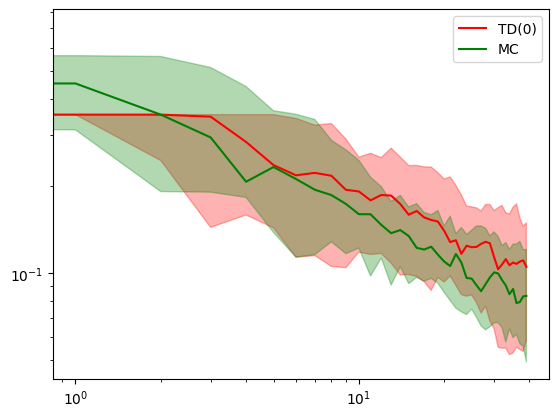

In [20]:
labels = ["TD(0)", "MC"]
colors = ["red", "green"]
plt.figure()
for i, res in enumerate([res_td0, res_mc]):
  errors = np.array([res[k][1] for k in range(n_runs)])
  plt.loglog(np.arange(n_samples), np.median(errors, axis=0), label = labels[i], color=colors[i])
  plt.fill_between(np.arange(n_samples), np.quantile(errors, 0.1, axis=0), np.quantile(errors, 0.9, axis=0), color=colors[i], alpha=0.3)
plt.legend()

# Reducing the variance of TD(0)

$TD(0)$ estimates the value $q^{\pi}$ of $\pi$ by iterating
$$
q_{t+1} = \alpha_t \tilde{T}^{\pi} q_t + (1 - \alpha_t) q_t
$$
where $\tilde{T}^{\pi}$ is defined by
$$\tilde{T}^{\pi}(q)(s, a) = r_a(s) + \gamma q(s2, a2) - q(s, a),~~ s_2 \sim P_a(s), a_2 \sim \pi(s_2).$$

$\tilde{T}^{\pi}$ is an (unbiased) estimate of
$$
  T^{\pi}(q)(s, a) = r_a(s) + \gamma \mathbb{E}_{s_2 \sim P_a(s), a_2 \sim \pi(s_2)}[q(s2, a2)] - q(s, a).
$$

Let us notice that the expectation with respect to $a_2$ can be computed exactly (since we know $\pi$) so we can use instead the estimate
$$\hat{T}^{\pi}(q)(s, a) = r_a(s) + \gamma \mathbb{E}_{a_2 \sim \pi(s_2)}[q(s2, a2)] - q(s, a),~~ s_2 \sim P_a(s)$$
which is still unbiased but has much less variance than $\tilde{T}^{\pi}$. So a better estimate of $q^{\pi}$ is given by iterating:
$$
q_{t+1} = \alpha_t \hat{T}^{\pi} q_t + (1 - \alpha_t) q_t
$$

# Exercise 4
Implement TD(0) with reduced variance as described in the answer to the question above.

In [21]:
def q_pi_td0_improved(pi, gamma, n_samples, step_size=lambda x: 1/x, q_true=None):
  """
  Estimate the q-value function using TD(0).
  In TD(0) given a pair (s, a, s') where s' is sampled from P_a(s),
  the updates are given by
  Q(s, a) = Q(s, a) + step_size (r_a(s) + gamma * E_{a_2}[Q(s2, a2)] - Q(s, a))
  where a_2 is sampled from pi( . | s_2)

  Parameter
  ---------
  pi: (n_actions, n_states) np array
    Policy
  gamma: float
    Discount factor
  n_samples: int
    Number of calls to the simulator for each state action pairs
  step_size: float -> float
    step_size function, the step-size used for the t-th trajectory is given by
    step_size(t) (by default it is set to 1/t).
  q_true: np array of size (n_states, n_actions)
    The state action value function returned using the model
  Return
  -------
  Q: np array of size (n_states, n_actions)
    q-value function
  errors: np array of size (n_trajectories,) (only returned if q_true is not None)
    l_infinity errors between the q_true and the current Q value.
  """
  rng = np.random
  n_actions, n_states = pi.shape
  Q = np.zeros((n_states, n_actions))
  errors = []
  for t in range(n_samples):
    if type(step_size) == float:
        alpha = step_size
    else:
        alpha = step_size(t+1)

    for s in range(n_states):
      env, pos = simulated_env(s)
      if pos == 'H' or pos == "G":
        Q[s, :]=0
      else:
        for a in range(n_actions):
          env.reset()
          s2, rew, term, trunc, _ = env.step(a)
          a2 = np.argmax(rng.multinomial(1, pi[:, s2]))
          Q[s,a] += alpha * (rew + gamma * np.sum([pi[a2,s2] * Q[s2, a2] for a2 in range(n_actions)]) - Q[s,a])
    if q_true is not None:
      errors.append(np.max(np.abs(Q - q_true)))
  if q_true is not None:
    return Q, errors
  return Q

In [22]:
n_samples = 40
n_runs = 20
step_size = lambda x: 1/x
res_td0_improved = Parallel(n_jobs=-1)(delayed(q_pi_td0_improved)(pi_uniform, gamma, n_samples, step_size=step_size, q_true=qpi_cf) for _ in range(n_runs))

(20, 40)
(20, 40)
(20, 40)


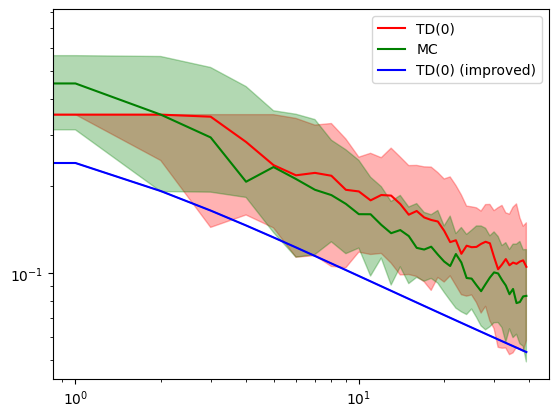

In [23]:
labels = ["TD(0)", "MC", "TD(0) (improved)"]
colors = ["red", "green", "blue"]
plt.figure()
for i, res in enumerate([res_td0, res_mc, res_td0_improved]):
  errors = np.array([res[k][1] for k in range(n_runs)])
  print(errors.shape)
  plt.loglog(np.arange(n_samples), np.median(errors, axis=0), label = labels[i], color=colors[i])
  plt.fill_between(np.arange(n_samples), np.quantile(errors, 0.1, axis=0), np.quantile(errors, 0.9, axis=0), color=colors[i], alpha=0.3)
plt.legend()

# Learning a state-action value function via TD(k) using a simulator
TD(k) is a generalization of TD(0) in that it estimates the operator $(T^{\pi})^k$ instead of $T^{\pi}$. The estimate is given by:
$$
\tilde{(T^\pi)^k (q)}(s, a) = r_a(s) + \gamma r_{A_1}(S_1) + \dots + \gamma^{k-1} r_{A_{k-1}}(S_{k-1}) + \gamma^k q(S_k, A_k)
$$
where $(S_0 = s, A_0 = a, \dots, S_k, A_k)$ is a trajectory given by the interation of the MDP and $\pi$ starting from state $s$ and action $a$.
TD(k=1) is equivalent to TD(0).

A possible implementation is as follows:

Starting from $\tilde{q}_0 = 0$ iterate
* For every state,action pair $(s, a)$ collect a samples $(S_0=s, A_0=a, ..., S_k, A_k)$ where $S_{i+1} \sim P_{A_i}(S_i)$ and $A_i \sim \pi(\cdot | S_i)$
* Perform for every $s, a$ the updates
$$
\tilde{q}_{t+1}(s, a) = \tilde{q}_t(s, a) + \alpha_t ( \tilde{(T^\pi)^k (q)}(s, a) -  \tilde{q}_t(s, a))
$$


# Exercise 5
Obtain an estimate of the state-action value function of the random policy using TD(k).

In [24]:
def q_pi_tdk(k, pi, gamma, n_samples, step_size=lambda x: 1/x, q_true=None):
  """
  Estimate the q-value function using TD(k)

  In TD(k) given (s_0=s, a_0=a, s_1, a_1, s_2, a_2, ..., s_k) where s_{i+1} \sim P_{a_i}(s_i) and a_i \sim pi(s_i),
  the updates are given by
  Q(s, a) = Q(s, a) + step_size (sum_{t=0}^{k-1} gamma^t r_{a_t}(s_t) + gamma^{k} Q(s_{k}, a_{k}) - Q(s, a))

  Parameter
  ---------
  k: int
    Parameter of the TD(k) algorithm
  pi: (n_actions, n_states) np array
    Policy
  gamma: float
    Discount factor
  n_calls: int
    Number of calls to the simulator (times that reset() is used)
  step_size: float -> float
    step_size function, the step-size used for the t-th trajectory is given by
    step_size(t) (by default it is set to 1/t).
  q_true: np array of size (n_states, n_actions)
    The state action value function returned using the model
  rng: int or None or or np.random.RandomState object
      The random seed / RandomState
  Return
  -------
  Q: np array of size (n_states, n_actions)
    q-value function
  errors: np array of size (n_trajectories,) (only returned if q_true is not None)
    l_infinity errors between the q_true and the current Q value.
  """
  rng = np.random
  n_actions, n_states = pi.shape
  Q = np.zeros((n_states, n_actions))
  errors = []
  for t in range(n_samples):
    if type(step_size) == float:
        alpha = step_size
    else:
        alpha = step_size(t+1)

    for s in range(n_states):
      env, pos = simulated_env(s)
      if pos == 'H' or pos == "G":
        Q[s, :]=0
      else:
        for a in range(n_actions):
          env.reset()
          a_i = a
          r_s = []
          for i in range(k):
            s_i, rew, term, trunc, _ = env.step(a_i)
            r_s.append(rew * gamma ** i)
            a_i = np.argmax(rng.multinomial(1, pi[:, s_i]))
          Q[s,a] += alpha * (np.sum(r_s) + gamma * Q[s_i, a_i] - Q[s,a])
    if q_true is not None:
      errors.append(np.max(np.abs(Q - q_true)))
  if q_true is not None:
    return Q, errors
  return Q

In [25]:
from tqdm import tqdm
# Plot bias variance trade-off
gamma = 0.9
qpi_cf = compute_qpi(env, pi_uniform, gamma)

n_samples = 20
n_runs = 200
ks = [1, 3, 5]
res_list = [
    Parallel(n_jobs=-1)(delayed(q_pi_tdk)(k, pi_uniform, gamma, n_samples, step_size, q_true=qpi_cf) for r in range(n_runs))
    for k in tqdm(ks)
]

100%|██████████| 3/3 [01:25<00:00, 28.41s/it]


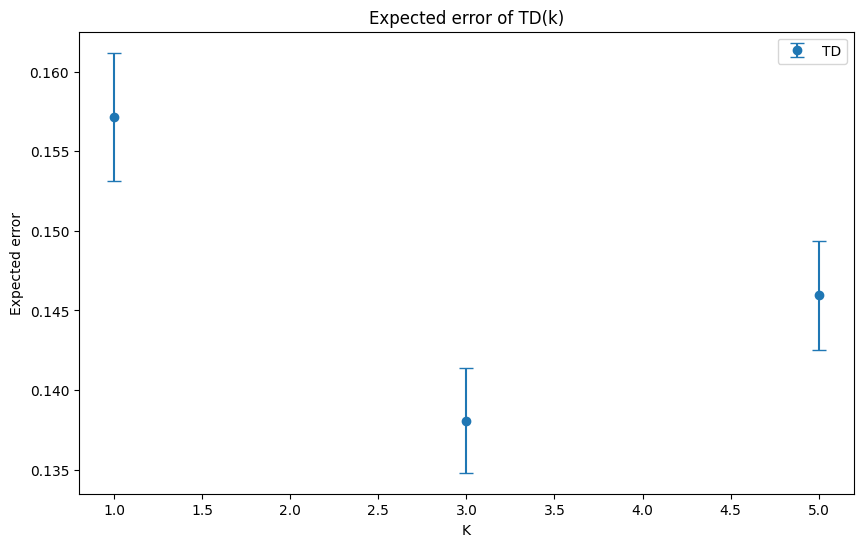

In [26]:
mean_error = np.array([np.mean(np.array([res[k][1] for k in range(n_runs)]), axis=0)[-1] for res in res_list])
err = np.array([np.std(np.array([res[k][1] for k in range(n_runs)]), axis=0)[-1] / np.sqrt(n_runs) for res in res_list])

plt.figure(figsize=(10, 6))
plt.errorbar(ks, mean_error, yerr=err, fmt='o', capsize=5, label='TD')
plt.xlabel('K')
plt.ylabel('Expected error')
plt.title('Expected error of TD(k)')
plt.legend()

# Exercise 6

How do you interpret the curve above ?

The U-shape of the curve is caused by the trade-off between bias and variance. As  𝑘  increases, the variance increases (as there is one more random term in the sum in the estimate of  𝑇𝜋 ) but the bias decreases (as the term  𝛾𝑘𝑄  from which the bias comes from decreases with  𝑘 ).

## Exercise 7
**Eligibility traces**

Consider the forward view of $TD(\lambda)$ where the goal is to estimate a fixed point of $(1 - \lambda) \sum_{k=0}^\infty \lambda^k T_{\pi}^k Q$ via stochastic approximation.

1. Show that $(1 - \lambda) \sum_{k=0}^\infty \lambda^k (T_{\pi}^k Q)(s, a) = \sum_{k=0}^{\infty} (\lambda \gamma)^k \mathbb{E}[\underbrace{r_{a_k}(s_k) + \gamma Q(s_{k+1}, a_{k+1}) - Q(s_k, a_k)}_{\delta_k} | s_0=s, a_0=a]$

2. Take $E_k(s, a) = 1\{\text{$k$ smallest integer such that $s_k, a_k = s, a$}\} + \lambda \gamma E_{k-1}(s, a)$. Show that we have
$(1 - \lambda) \sum_{k=0}^\infty \lambda^k (T_{\pi}^k Q)(s, a) = \sum_{k=0}^{\infty}  \mathbb{E}[E_k(s_l, a_l) \delta_{k+l} | s_l=s, a_l=a]$


When we play along a trajectory
$(s_0, a_0, ...,)$ we can see it as playing many trajectories from different starting point:
$(s_0, a_0, s_1, a_1, s_2, a_2,...), (s_1, a_1, ...), (s_2, a_2, ...), ...$.
We can use them to update the estimate of $(1 - \lambda) \sum_{k=0}^\infty \lambda^k T_{\pi}^k$ at multiple points $(s, a)$ and update them simultaneously.

The resulting algorithm in pseudo-code is given by:

```
N[s, a] = 0 forall s, a
for n_iterations
  for every state action pair (s_0, a_0)
    Set E_0[s, a] = 0 for all s, a
    Set N_g[s, a] = 0 for all s, a
    Sample a trajectory (S_0, A_0, ..., ) starting at S_0, A_0 = s_0, a_0
    At step k, (S_k, A_k) is played, we observe S_{k+1} and R_{A_k}(S_k)
    - Set E_k[s, a] = gamma lambda E_{k-1}[s, a] for all s, a
    - Set E[S_k, A_k] += 1
    - delta_k = R_{A_k}(S_k) + gamma * \sum_{a} Q(S_{k+1}, a) pi(a | S_{k+1})  
    - Set G[s, a] += E_k[s, a] * delta_k for all s, a
    - Set N_g[S_k, A_k] += 1
    - Set N[S_k, A_k] += 1
  Set Q += G / (N_g[S_k, A_k] * N[S_k, A_k])
```

__Practical tricks__

In practice, $Q$ is updated online. The iterations are given by:
```
N[s, a] = 0 forall s, a
for n_iterations
  for every state action pair (s_0, a_0)
    Set E_0[s, a] = 0 for all s, a
    Sample a trajectory (S_0, A_0, ..., ) starting at S_0, A_0 = s_0, a_0
    At step k, (S_k, A_k) is played, we observe S_{k+1} and R_{A_k}(S_k)
    - Set E_k[s, a] = gamma lambda E_{k-1}[s, a] for all s, a
    - delta_k = R_{A_k}(S_k) + gamma * \sum_{a} Q(S_{k+1}, a) pi(a | S_{k+1})
    - Set E[S_k, A_k] += 1
    - Set Q[s, a] +=  E_k[s, a] * \delta_k / N[s, a] for all s, a
    - Set N[S_k, A_k] += 1
```

## Exercise 8
Implement $TD(\lambda)$ via Eligibilitiy traces. Use the online version presented in the pseudo code above.

In [30]:
def q_pi_tdlambda(l, pi, gamma, n_samples, step_size=lambda x: 1/x, seed=0, max_horizon=100, q_true=None):
  """
  Estimate the q-value function using TD(lambda) algorithm.
  Use the Eligibility trace implementation.

  Parameter
  ---------
  l: float
    Parameter of the TD(lambda) algorithm
  pi: (n_actions, n_states) np array
    Policy
  gamma: float
    Discount factor
  max_horizon: int
    For each trajectories, if after max_horizon steps,
    no terminal state is reached, the computation stops
    with a return of 0.
  n_calls: int
    Number of calls to the simulator (times that reset() is used)
  step_size: float -> float
    step_size function, the step-size used for the t-th trajectory is given by
    step_size(t) (by default it is set to 1/t).
  seed: int
    Random seed
  q_true: np array of size (n_states, n_actions)
    The state action value function returned using the model
  rng: int or None or or np.random.RandomState object
      The random seed / RandomState
  Return
  -------
  Q: np array of size (n_states, n_actions)
    q-value function
  errors: np array of size (n_trajectories,) (only returned if q_true is not None)
    l_infinity errors between the q_true and the current Q value.
  """
  rng = np.random
  n_actions, n_states = pi.shape
  N = np.zeros((n_states, n_actions))
  Q = np.zeros((n_states, n_actions))
  errors = []
  for t in range(n_samples):
    if type(step_size) == float:
      alpha = step_size
    else:
      alpha = step_size(t+1)
    E = np.zeros((n_states, n_actions))
    for s0 in range(n_states):
      env, pos = simulated_env(s0)
      if pos == "H" or pos == "G":
        Q[s0, :] = 0
      else:
        for a0 in range(n_actions):
          env.reset()
          a = a0
          s = s0
          Gt = 0
          for step in range(max_horizon):
            E = gamma * l * E
            E[s, a] += 1
            s2, rew, term, trunc, _ = env.step(a)
            a2 = np.argmax(rng.multinomial(1, pi[:, s]))
            delta = rew + gamma * np.sum([Q[s2, a2] * pi[a2, s2] for a2 in range(n_actions)]) - Q[s, a]
            Q += alpha * delta * E
            s = s2
            a = a2
    if q_true is not None:
      errors.append(np.max(np.abs(Q - q_true)))
  if q_true is not None:
    return Q, errors
  return Q

In [ ]:
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
gamma = 0.9
qpi_cf = compute_qpi(env, pi_uniform, gamma)
# Compute the expected l infinity error for 100 trajectories for different step size functions
# Use step_size = 1/t, 1/10

n_samples = 10
n_runs = 20
step_size = lambda x: 1/x
ls = np.linspace(0, 1, 20)
res_list = [Parallel(n_jobs=-1)(delayed(q_pi_tdlambda)(l, pi_uniform, gamma, n_samples, step_size, q_true=qpi_cf) for r in range(n_runs)) for l in tqdm(ls)]

 40%|████      | 8/20 [04:26<06:34, 32.90s/it]

In [29]:
mean_error = np.array([np.mean(np.array([res[k][1] for k in range(n_runs)]), axis=0)[-1] for res in res_list])
err = np.array([np.std(np.array([res[k][1] for k in range(n_runs)]), axis=0)[-1] / np.sqrt(n_runs) for res in res_list])

plt.figure(figsize=(10, 6))
plt.errorbar(ls, mean_error, yerr=err, fmt='o', capsize=5, label='TD(\lambda)')
plt.xlabel('lambda')
plt.ylabel('Expected error')
plt.yscale("log")
plt.legend()

TypeError: 'NoneType' object is not subscriptable

# Exercise 9

Explain the shape of the curve

Answer:

Let us call $\hat{T}^{\pi, k}$ the estimate of $T^{\pi}$ in $TD(k)$. The estimate of $T^\pi$ in $TD(\lambda)$ is given by $\mathbb{E}_{K \sim G(\lambda)} [\hat{T}^{\pi, K}]$ where $G(\lambda)$ is a geometric distribution of parameter $\lambda$. For any $\lambda < \lambda'$, $\mathbb{P}_{K \sim G(\lambda)}(K \geq x) \leq \mathbb{P}_{K \sim G(\lambda')}(K \geq x)$ and higher values of $k$ in $\hat{T}^{\pi, k}$ is associated with lower bias and higher variance. This explains the shape of the curve.